In [3]:
import pandas as pd
from tensorflow import keras
import tensorflow as tf
import random
from sklearn.utils import shuffle
import scipy.stats
from zipfile import ZipFile 
import optuna
from sklearn.model_selection import train_test_split

In [4]:
import time
from tensorflow.keras import layers, regularizers
from tensorflow.keras.utils import to_categorical
import time
from tensorflow.keras import layers, regularizers
from tensorflow.keras.utils import to_categorical
import numpy as np

In [5]:
import os
import shutil
from scipy import io #for loadmat, matlab conversion
import numpy as np
import matplotlib.pyplot as plt # for plotting training curves
#from tensorflow import keras #added to save model
from tensorflow.keras import layers #format matches MNIST example
#imports for computing and displaying output metrics
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

In [6]:
def process_eeg_data(x, y):
    new_x =[]
    new_y = []
    split_size = 178
    n_splits = 23
    for i in range(x.shape[0]):
        sub_data = x[i]
        y_val = y[i]
        for i in range (n_splits):
            sample = sub_data[i*split_size:(i+1)*split_size]
            new_x.append(sample)
            temp_y = y_val
            new_y.append(temp_y)
            #print(sample.shape)
            
    new_x = np.array(new_x)
    new_y = np.array(new_y)
    # x = new_x
    # y = new_y
    return new_x, new_y

In [7]:
def load_eeg_data():
    input_dir = 'eeg_dataset_1/'
    x_train = np.load(input_dir +'x_train.npy')
    x_validation = np.load(input_dir +'x_valid.npy')
    x_test = np.load(input_dir +'x_test.npy')
    y_train = np.load(input_dir +'y_train.npy')
    y_validation = np.load(input_dir +'y_valid.npy')
    y_test = np.load(input_dir +'y_test.npy')
    
    x_train = x_train.astype(float)
    x_validation = x_validation.astype(float)
    x_test = x_test.astype(float)
    
    x_train, y_train = process_eeg_data(x_train, y_train)
    x_validation, y_validation = process_eeg_data(x_validation, y_validation)
    x_test, y_test = process_eeg_data(x_test, y_test)
    
    
    return x_train, y_train, x_validation, y_validation, x_test, y_test

In [8]:
x_train, y_train, x_validate, y_validate, x_test, y_test \
                             = load_eeg_data()

In [9]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[2], x_train.shape[1])
x_validate = x_validate.reshape(x_validate.shape[0], x_validate.shape[2], x_validate.shape[1])
x_test = x_test.reshape(x_test.shape[0], x_test.shape[2], x_test.shape[1])
print(x_train.shape, y_train.shape)
print(x_validate.shape, y_validate.shape)
print(x_test.shape, y_test.shape)

(6900, 1, 178) (6900, 2)
(2300, 1, 178) (2300, 2)
(2300, 1, 178) (2300, 2)


In [10]:
def rnn_model_1(x_train, y_train, n_units):
    n_features, n_timesteps, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[1]
    
    model = keras.Sequential(
        [
            keras.Input(shape=(n_features, n_timesteps)),
            # layers.SimpleRNN(200, return_sequences=True, activation='relu'),
            # layers.Dropout(0.1),
            layers.SimpleRNN(n_units, activation='relu'),
            layers.Dropout(0.1),
            layers.Dense(100, activation='relu'),
            layers.Dense(n_outputs, activation='softmax')
        ]
    )
    return model

In [11]:
units_arr = [10, 20, 30, 50, 100, 200, 500, 1000]
BATCH_SIZE = 32     # Typical values are 8, 16 or 32
NUM_EPOCHS = 30
val_acc_arr = []
pred_acc_arr = []
time_arr = []
keras.backend.clear_session()
for n_units in units_arr:
    model = rnn_model_1(x_train, y_train, n_units)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    print(model.summary())
    start = time.time()
    history = model.fit(
            x_train,y_train,
            steps_per_epoch=x_train.shape[0]//BATCH_SIZE,
            epochs=NUM_EPOCHS,
            validation_data=(x_validate,y_validate),
            validation_steps=x_validate.shape[0]//BATCH_SIZE)
    
    print("Final Validation Accuracy: %0.3f" % history.history['val_accuracy'][-1])
    end = time.time()
    predictions = model.predict(x_test, verbose=0,batch_size=32)
    
    #must use values not one-hot encoding, use argmax to convert
    y_pred = np.argmax(predictions, axis=-1) # axis=-1 means last axis
    y_test_act = np.argmax(y_test, axis=-1) # undo one-hot encoding
    
    # Print print prediction accuracy
    print('Num units: ',n_units)
    print('Prediction accuracy: {0:.3f}'.format(accuracy_score(y_test_act, y_pred)))
    print('Time in sec: ' ,end-start)
    val_acc_arr.append(history.history['val_accuracy'][-1])
    pred_acc_arr.append(accuracy_score(y_test_act, y_pred))
    time_arr.append(end-start)
    
    keras.backend.clear_session()

2024-04-26 23:30:18.368043: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 10)             │         1,890 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │         1,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,192 (12.47 KB)

 Trainable params: 3,192 (12.47 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
183/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6028 - loss: 7.5999

2024-04-26 23:30:19.517025: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/tljh/user/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6062 - loss: 7.1214 - val_accuracy: 0.6139 - val_loss: 1.6835
Epoch 2/30
129/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7091 - loss: 1.5904

2024-04-26 23:30:19.729584: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7257 - loss: 1.4560 - val_accuracy: 0.8130 - val_loss: 0.9498
Epoch 3/30
 91/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8204 - loss: 0.8569

2024-04-26 23:30:20.015050: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:20.076590: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8270 - loss: 0.7788 - val_accuracy: 0.8578 - val_loss: 0.8262
Epoch 4/30
 45/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8738 - loss: 0.4672 

2024-04-26 23:30:20.346282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:20.404980: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8655 - loss: 0.5320 - val_accuracy: 0.8709 - val_loss: 0.5733
Epoch 5/30
128/215 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - accuracy: 0.9017 - loss: 0.3892

2024-04-26 23:30:20.688862: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:20.738455: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8985 - loss: 0.3965 - val_accuracy: 0.8304 - val_loss: 0.5640
Epoch 6/30
125/215 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - accuracy: 0.9072 - loss: 0.3889

2024-04-26 23:30:20.943179: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:20.996406: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9066 - loss: 0.4001 - val_accuracy: 0.8830 - val_loss: 0.3912
Epoch 7/30
127/215 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - accuracy: 0.9275 - loss: 0.2937

2024-04-26 23:30:21.208345: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:21.260760: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9244 - loss: 0.2948 - val_accuracy: 0.8913 - val_loss: 0.3574
Epoch 8/30
 66/215 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - accuracy: 0.9282 - loss: 0.2766

2024-04-26 23:30:21.472700: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:21.531323: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9261 - loss: 0.2820 - val_accuracy: 0.9091 - val_loss: 0.3191
Epoch 9/30
121/215 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - accuracy: 0.9278 - loss: 0.2376

2024-04-26 23:30:21.742427: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:21.794310: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9252 - loss: 0.2610 - val_accuracy: 0.9017 - val_loss: 0.3923
Epoch 10/30
 62/215 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - accuracy: 0.9242 - loss: 0.3139

2024-04-26 23:30:22.009665: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:22.069389: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9240 - loss: 0.3112 - val_accuracy: 0.9226 - val_loss: 0.2561
Epoch 11/30
124/215 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - accuracy: 0.9408 - loss: 0.2118

2024-04-26 23:30:22.283091: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:22.335207: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9369 - loss: 0.2313 - val_accuracy: 0.9165 - val_loss: 0.3003
Epoch 12/30
125/215 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - accuracy: 0.9453 - loss: 0.1890

2024-04-26 23:30:22.543151: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:22.593297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9435 - loss: 0.2027 - val_accuracy: 0.9178 - val_loss: 0.2881
Epoch 13/30
125/215 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - accuracy: 0.9504 - loss: 0.1867

2024-04-26 23:30:22.803087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:22.857774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9479 - loss: 0.2013 - val_accuracy: 0.9270 - val_loss: 0.2741
Epoch 14/30
124/215 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - accuracy: 0.9485 - loss: 0.2201

2024-04-26 23:30:23.068931: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:23.123937: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9458 - loss: 0.2278 - val_accuracy: 0.9270 - val_loss: 0.2674
Epoch 15/30
122/215 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - accuracy: 0.9509 - loss: 0.1560

2024-04-26 23:30:23.335176: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:23.389224: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9498 - loss: 0.1710 - val_accuracy: 0.9335 - val_loss: 0.2148
Epoch 16/30
 57/215 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - accuracy: 0.9525 - loss: 0.1723

2024-04-26 23:30:23.606408: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:23.663639: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9523 - loss: 0.1856 - val_accuracy: 0.9257 - val_loss: 0.2212
Epoch 17/30
117/215 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - accuracy: 0.9555 - loss: 0.1633

2024-04-26 23:30:23.892872: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:23.949754: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9540 - loss: 0.1712 - val_accuracy: 0.9304 - val_loss: 0.2613
Epoch 18/30
127/215 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - accuracy: 0.9531 - loss: 0.1331

2024-04-26 23:30:24.170515: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:24.223172: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9532 - loss: 0.1433 - val_accuracy: 0.9104 - val_loss: 0.3230
Epoch 19/30
123/215 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - accuracy: 0.9419 - loss: 0.2593

2024-04-26 23:30:24.428192: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:24.477868: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9429 - loss: 0.2489 - val_accuracy: 0.9291 - val_loss: 0.2583
Epoch 20/30
119/215 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - accuracy: 0.9529 - loss: 0.2026

2024-04-26 23:30:24.689694: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:24.743094: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9473 - loss: 0.2321 - val_accuracy: 0.9278 - val_loss: 0.2502
Epoch 21/30
102/215 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - accuracy: 0.9548 - loss: 0.1744

2024-04-26 23:30:24.954152: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:25.008052: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9512 - loss: 0.1894 - val_accuracy: 0.9270 - val_loss: 0.2522
Epoch 22/30
 98/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9625 - loss: 0.1679

2024-04-26 23:30:25.262849: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:25.320103: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9557 - loss: 0.1914 - val_accuracy: 0.9313 - val_loss: 0.2266
Epoch 23/30
103/215 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - accuracy: 0.9559 - loss: 0.1427

2024-04-26 23:30:25.575064: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:25.629317: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9536 - loss: 0.1648 - val_accuracy: 0.9278 - val_loss: 0.2692
Epoch 24/30
105/215 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - accuracy: 0.9522 - loss: 0.1986

2024-04-26 23:30:25.895108: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:25.949679: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9518 - loss: 0.1998 - val_accuracy: 0.9365 - val_loss: 0.2720
Epoch 25/30
101/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9606 - loss: 0.1599

2024-04-26 23:30:26.195627: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:26.248707: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9594 - loss: 0.1606 - val_accuracy: 0.9378 - val_loss: 0.2076
Epoch 26/30
105/215 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - accuracy: 0.9625 - loss: 0.1766

2024-04-26 23:30:26.499191: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:26.551771: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9610 - loss: 0.1737 - val_accuracy: 0.9261 - val_loss: 0.2431
Epoch 27/30
142/215 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - accuracy: 0.9485 - loss: 0.1976

2024-04-26 23:30:26.790260: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:26.847961: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9493 - loss: 0.1936 - val_accuracy: 0.9417 - val_loss: 0.2006
Epoch 28/30
133/215 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step - accuracy: 0.9678 - loss: 0.1202

2024-04-26 23:30:27.035364: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:27.087290: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9654 - loss: 0.1313 - val_accuracy: 0.9343 - val_loss: 0.2681
Epoch 29/30
127/215 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - accuracy: 0.9521 - loss: 0.1726

2024-04-26 23:30:27.292288: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:27.344046: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9506 - loss: 0.1846 - val_accuracy: 0.9339 - val_loss: 0.2139
Epoch 30/30
126/215 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - accuracy: 0.9523 - loss: 0.2147

2024-04-26 23:30:27.554559: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:27.611189: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9531 - loss: 0.2040 - val_accuracy: 0.9435 - val_loss: 0.1900
Final Validation Accuracy: 0.943


2024-04-26 23:30:27.819583: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:27.873927: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Num units:  10
Prediction accuracy: 0.962
Time in sec:  9.478646993637085


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 20)             │         3,980 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │         2,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,282 (24.54 KB)

 Trainable params: 6,282 (24.54 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
184/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5537 - loss: 10.1270 

2024-04-26 23:30:29.407038: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/tljh/user/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5620 - loss: 9.6040 - val_accuracy: 0.6704 - val_loss: 2.8384
Epoch 2/30
147/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7210 - loss: 2.3788

2024-04-26 23:30:29.611400: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7241 - loss: 2.3500 - val_accuracy: 0.7543 - val_loss: 2.0197
Epoch 3/30
104/215 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - accuracy: 0.7521 - loss: 1.8534

2024-04-26 23:30:29.875906: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:29.929011: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7632 - loss: 1.7277 - val_accuracy: 0.8017 - val_loss: 1.3664
Epoch 4/30
 99/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8235 - loss: 1.3835

2024-04-26 23:30:30.173943: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:30.228068: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8259 - loss: 1.2439 - val_accuracy: 0.8374 - val_loss: 1.0653
Epoch 5/30
 95/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8594 - loss: 0.8539

2024-04-26 23:30:30.484907: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:30.540045: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8532 - loss: 0.8586 - val_accuracy: 0.8526 - val_loss: 1.0026
Epoch 6/30
101/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8840 - loss: 0.6476

2024-04-26 23:30:30.798933: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:30.853683: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8815 - loss: 0.6820 - val_accuracy: 0.8643 - val_loss: 0.8296
Epoch 7/30
 44/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8948 - loss: 0.5945 

2024-04-26 23:30:31.108857: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:31.170816: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8978 - loss: 0.5426 - val_accuracy: 0.8248 - val_loss: 0.8680
Epoch 8/30
117/215 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - accuracy: 0.8689 - loss: 0.6192

2024-04-26 23:30:31.439351: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:31.495072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8828 - loss: 0.5614 - val_accuracy: 0.8704 - val_loss: 0.6609
Epoch 9/30
 48/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9040 - loss: 0.5446 

2024-04-26 23:30:31.718489: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:31.778617: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9140 - loss: 0.4450 - val_accuracy: 0.8848 - val_loss: 0.7896
Epoch 10/30
100/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9135 - loss: 0.4131

2024-04-26 23:30:32.039756: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:32.097551: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9168 - loss: 0.3896 - val_accuracy: 0.8591 - val_loss: 0.7271
Epoch 11/30
108/215 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - accuracy: 0.9121 - loss: 0.5185

2024-04-26 23:30:32.346517: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:32.399727: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9158 - loss: 0.4635 - val_accuracy: 0.9048 - val_loss: 0.7600
Epoch 12/30
 68/215 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - accuracy: 0.8974 - loss: 0.6049

2024-04-26 23:30:32.634734: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:32.693546: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9042 - loss: 0.5289 - val_accuracy: 0.8974 - val_loss: 0.4627
Epoch 13/30
109/215 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - accuracy: 0.9340 - loss: 0.2763

2024-04-26 23:30:32.897738: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:32.947436: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9342 - loss: 0.2901 - val_accuracy: 0.8700 - val_loss: 0.5971
Epoch 14/30
136/215 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - accuracy: 0.9217 - loss: 0.3641

2024-04-26 23:30:33.194027: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:33.250684: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9241 - loss: 0.3571 - val_accuracy: 0.8978 - val_loss: 0.4571
Epoch 15/30
140/215 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - accuracy: 0.9452 - loss: 0.2751

2024-04-26 23:30:33.446699: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:33.494825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - accuracy: 0.9452 - loss: 0.2661 - val_accuracy: 0.9157 - val_loss: 0.3926
Epoch 16/30
134/215 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - accuracy: 0.9430 - loss: 0.2909

2024-04-26 23:30:33.683702: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:33.730919: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9434 - loss: 0.2855 - val_accuracy: 0.9070 - val_loss: 0.4251
Epoch 17/30
139/215 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - accuracy: 0.9496 - loss: 0.2492

2024-04-26 23:30:33.933269: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:33.983105: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9483 - loss: 0.2509 - val_accuracy: 0.9004 - val_loss: 0.4400
Epoch 18/30
134/215 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step - accuracy: 0.9573 - loss: 0.1952

2024-04-26 23:30:34.181892: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:34.230384: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9568 - loss: 0.1926 - val_accuracy: 0.9200 - val_loss: 0.4773
Epoch 19/30
131/215 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - accuracy: 0.9485 - loss: 0.2379

2024-04-26 23:30:34.427686: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:34.476079: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9479 - loss: 0.2382 - val_accuracy: 0.9265 - val_loss: 0.2912
Epoch 20/30
129/215 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - accuracy: 0.9488 - loss: 0.2085

2024-04-26 23:30:34.681260: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:34.731470: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9503 - loss: 0.2076 - val_accuracy: 0.9252 - val_loss: 0.3065
Epoch 21/30
127/215 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - accuracy: 0.9520 - loss: 0.2227

2024-04-26 23:30:34.933442: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:34.983219: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9517 - loss: 0.2223 - val_accuracy: 0.9178 - val_loss: 0.3423
Epoch 22/30
133/215 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - accuracy: 0.9207 - loss: 0.4911

2024-04-26 23:30:35.189704: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:35.244890: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9261 - loss: 0.4317 - val_accuracy: 0.9013 - val_loss: 0.3790
Epoch 23/30
128/215 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - accuracy: 0.9420 - loss: 0.2128

2024-04-26 23:30:35.446022: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:35.496611: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9450 - loss: 0.2062 - val_accuracy: 0.9135 - val_loss: 0.5931
Epoch 24/30
128/215 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - accuracy: 0.9554 - loss: 0.2035

2024-04-26 23:30:35.700675: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:35.751360: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9551 - loss: 0.2003 - val_accuracy: 0.9170 - val_loss: 0.3300
Epoch 25/30
116/215 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - accuracy: 0.9473 - loss: 0.2076

2024-04-26 23:30:35.961366: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:36.014358: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9484 - loss: 0.2131 - val_accuracy: 0.9213 - val_loss: 0.3105
Epoch 26/30
102/215 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - accuracy: 0.9684 - loss: 0.1191

2024-04-26 23:30:36.236797: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:36.290072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9682 - loss: 0.1246 - val_accuracy: 0.9022 - val_loss: 0.3729
Epoch 27/30
126/215 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step - accuracy: 0.9552 - loss: 0.1658

2024-04-26 23:30:36.548582: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:36.606602: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9587 - loss: 0.1543 - val_accuracy: 0.9304 - val_loss: 0.2479
Epoch 28/30
125/215 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - accuracy: 0.9615 - loss: 0.1391

2024-04-26 23:30:36.818638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:36.871684: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9592 - loss: 0.1596 - val_accuracy: 0.9265 - val_loss: 0.4235
Epoch 29/30
130/215 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - accuracy: 0.9538 - loss: 0.2047

2024-04-26 23:30:37.082442: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:37.131107: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9557 - loss: 0.1967 - val_accuracy: 0.9348 - val_loss: 0.2307
Epoch 30/30
143/215 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - accuracy: 0.9633 - loss: 0.1649

2024-04-26 23:30:37.330663: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:37.378447: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - accuracy: 0.9607 - loss: 0.1785 - val_accuracy: 0.8513 - val_loss: 0.6066
Final Validation Accuracy: 0.851


2024-04-26 23:30:37.561940: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:37.607101: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Num units:  20
Prediction accuracy: 0.877
Time in sec:  9.289943218231201


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 30)             │         6,270 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │         3,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,572 (37.39 KB)

 Trainable params: 9,572 (37.39 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
205/215 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - accuracy: 0.5798 - loss: 13.3881

2024-04-26 23:30:39.064638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/tljh/user/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5830 - loss: 13.1225 - val_accuracy: 0.7509 - val_loss: 3.6874
Epoch 2/30
156/215 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - accuracy: 0.7594 - loss: 2.8360

2024-04-26 23:30:39.272558: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7587 - loss: 2.8081 - val_accuracy: 0.7765 - val_loss: 2.6115
Epoch 3/30
102/215 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - accuracy: 0.8045 - loss: 1.7702

2024-04-26 23:30:39.527696: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:39.583954: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8022 - loss: 1.7375 - val_accuracy: 0.7448 - val_loss: 1.9884
Epoch 4/30
135/215 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - accuracy: 0.8081 - loss: 1.5605

2024-04-26 23:30:39.830739: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:39.886242: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8139 - loss: 1.4805 - val_accuracy: 0.7165 - val_loss: 1.7662
Epoch 5/30
119/215 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - accuracy: 0.7644 - loss: 1.7701

2024-04-26 23:30:40.087766: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:40.139959: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7930 - loss: 1.4835 - val_accuracy: 0.8143 - val_loss: 1.4545
Epoch 6/30
107/215 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - accuracy: 0.8642 - loss: 0.8772

2024-04-26 23:30:40.365647: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:40.420102: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8690 - loss: 0.8258 - val_accuracy: 0.8504 - val_loss: 1.1268
Epoch 7/30
 89/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8905 - loss: 0.6550

2024-04-26 23:30:40.654145: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:40.709154: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8877 - loss: 0.6120 - val_accuracy: 0.8391 - val_loss: 0.9680
Epoch 8/30
 43/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9057 - loss: 0.4317 

2024-04-26 23:30:40.988918: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:41.066694: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9079 - loss: 0.4193 - val_accuracy: 0.8696 - val_loss: 0.9919
Epoch 9/30
126/215 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - accuracy: 0.9063 - loss: 0.5378

2024-04-26 23:30:41.315936: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:41.364095: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9047 - loss: 0.5199 - val_accuracy: 0.8617 - val_loss: 0.8213
Epoch 10/30
124/215 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - accuracy: 0.8973 - loss: 0.4837

2024-04-26 23:30:41.573381: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:41.624149: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9039 - loss: 0.4415 - val_accuracy: 0.8270 - val_loss: 0.8514
Epoch 11/30
 51/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8612 - loss: 0.5645 

2024-04-26 23:30:41.840417: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:41.902620: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8998 - loss: 0.4488 - val_accuracy: 0.8709 - val_loss: 0.5434
Epoch 12/30
134/215 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - accuracy: 0.9462 - loss: 0.1976

2024-04-26 23:30:42.141911: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:42.197952: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9444 - loss: 0.2126 - val_accuracy: 0.9026 - val_loss: 0.5303
Epoch 13/30
133/215 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step - accuracy: 0.9497 - loss: 0.2441

2024-04-26 23:30:42.393993: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:42.445426: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9444 - loss: 0.2640 - val_accuracy: 0.8787 - val_loss: 0.5195
Epoch 14/30
123/215 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - accuracy: 0.8872 - loss: 0.5823

2024-04-26 23:30:42.645670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:42.698399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9009 - loss: 0.5031 - val_accuracy: 0.8970 - val_loss: 0.4449
Epoch 15/30
 48/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9380 - loss: 0.2012 

2024-04-26 23:30:42.939239: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:43.002749: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9460 - loss: 0.2050 - val_accuracy: 0.8974 - val_loss: 0.6766
Epoch 16/30
135/215 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - accuracy: 0.9375 - loss: 0.2491

2024-04-26 23:30:43.231175: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:43.287056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9401 - loss: 0.2484 - val_accuracy: 0.9070 - val_loss: 0.4046
Epoch 17/30
125/215 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - accuracy: 0.9565 - loss: 0.1943

2024-04-26 23:30:43.482496: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:43.530991: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9547 - loss: 0.1988 - val_accuracy: 0.9126 - val_loss: 0.4288
Epoch 18/30
 44/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9406 - loss: 0.2546 

2024-04-26 23:30:43.740589: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:43.802309: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9449 - loss: 0.2188 - val_accuracy: 0.9139 - val_loss: 0.3768
Epoch 19/30
134/215 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - accuracy: 0.9584 - loss: 0.1372

2024-04-26 23:30:44.085142: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:44.135075: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9573 - loss: 0.1477 - val_accuracy: 0.9178 - val_loss: 0.4364
Epoch 20/30
129/215 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - accuracy: 0.9679 - loss: 0.1414

2024-04-26 23:30:44.331577: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:44.379566: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9645 - loss: 0.1467 - val_accuracy: 0.9248 - val_loss: 0.3109
Epoch 21/30
118/215 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - accuracy: 0.9683 - loss: 0.1240

2024-04-26 23:30:44.583914: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:44.636789: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9654 - loss: 0.1381 - val_accuracy: 0.9117 - val_loss: 0.3346
Epoch 22/30
 43/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9732 - loss: 0.0959 

2024-04-26 23:30:44.874230: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:44.936508: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9678 - loss: 0.1270 - val_accuracy: 0.9261 - val_loss: 0.2984
Epoch 23/30
 89/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9680 - loss: 0.1394

2024-04-26 23:30:45.188837: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:45.243760: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9670 - loss: 0.1295 - val_accuracy: 0.8926 - val_loss: 0.3692
Epoch 24/30
 47/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9619 - loss: 0.1522 

2024-04-26 23:30:45.524803: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:45.583766: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9610 - loss: 0.1546 - val_accuracy: 0.9252 - val_loss: 0.3819
Epoch 25/30
 88/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9759 - loss: 0.0849

2024-04-26 23:30:45.860317: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:45.910420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9733 - loss: 0.0986 - val_accuracy: 0.9352 - val_loss: 0.3369
Epoch 26/30
 47/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9737 - loss: 0.1471 

2024-04-26 23:30:46.193802: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:46.258396: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9730 - loss: 0.1145 - val_accuracy: 0.9296 - val_loss: 0.2881
Epoch 27/30
 45/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9805 - loss: 0.0870 

2024-04-26 23:30:46.535227: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:46.593155: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9732 - loss: 0.1008 - val_accuracy: 0.9304 - val_loss: 0.2880
Epoch 28/30
113/215 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - accuracy: 0.9754 - loss: 0.0986

2024-04-26 23:30:46.852699: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:46.903302: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9746 - loss: 0.1044 - val_accuracy: 0.9204 - val_loss: 0.3241
Epoch 29/30
127/215 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step - accuracy: 0.9671 - loss: 0.1070

2024-04-26 23:30:47.116815: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:47.169441: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9666 - loss: 0.1239 - val_accuracy: 0.9365 - val_loss: 0.2190
Epoch 30/30
 90/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9788 - loss: 0.0928

2024-04-26 23:30:47.386413: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:47.442106: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9752 - loss: 0.1048 - val_accuracy: 0.9326 - val_loss: 0.2962
Final Validation Accuracy: 0.933


2024-04-26 23:30:47.720252: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:47.782056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Num units:  30
Prediction accuracy: 0.940
Time in sec:  9.754751443862915


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 50)             │        11,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │         5,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,752 (65.44 KB)

 Trainable params: 16,752 (65.44 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
204/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6480 - loss: 10.9969

2024-04-26 23:30:49.313304: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/tljh/user/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-04-26 23:30:49.513462: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6500 - loss: 10.8028 - val_accuracy: 0.7591 - val_loss: 4.1831
Epoch 2/30
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7777 - loss: 3.0697 - val_accuracy: 0.7517 - val_loss: 3.4388
Epoch 3/30
 50/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8135 - loss: 2.0762 

2024-04-26 23:30:49.786713: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:49.848839: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8117 - loss: 2.1197 - val_accuracy: 0.7696 - val_loss: 2.6962
Epoch 4/30
107/215 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - accuracy: 0.8383 - loss: 1.8451

2024-04-26 23:30:50.110912: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:50.166821: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8360 - loss: 1.7597 - val_accuracy: 0.7348 - val_loss: 2.3151
Epoch 5/30
120/215 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - accuracy: 0.8308 - loss: 1.4705

2024-04-26 23:30:50.402354: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:50.458533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8359 - loss: 1.4165 - val_accuracy: 0.7048 - val_loss: 2.5011
Epoch 6/30
121/215 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - accuracy: 0.8529 - loss: 0.9720

2024-04-26 23:30:50.675529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:50.726267: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8597 - loss: 0.9562 - val_accuracy: 0.8465 - val_loss: 1.8543
Epoch 7/30
118/215 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - accuracy: 0.8881 - loss: 0.7391

2024-04-26 23:30:50.942279: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:50.995773: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8870 - loss: 0.7448 - val_accuracy: 0.8483 - val_loss: 1.5286
Epoch 8/30
125/215 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - accuracy: 0.9050 - loss: 0.6109

2024-04-26 23:30:51.215242: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:51.264132: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9028 - loss: 0.6184 - val_accuracy: 0.8117 - val_loss: 1.3150
Epoch 9/30
116/215 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - accuracy: 0.9131 - loss: 0.4531

2024-04-26 23:30:51.475746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:51.528065: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9118 - loss: 0.4696 - val_accuracy: 0.8100 - val_loss: 1.2368
Epoch 10/30
111/215 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - accuracy: 0.9147 - loss: 0.4411

2024-04-26 23:30:51.747149: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:51.799120: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9151 - loss: 0.4312 - val_accuracy: 0.8339 - val_loss: 1.0905
Epoch 11/30
119/215 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - accuracy: 0.9286 - loss: 0.3695

2024-04-26 23:30:52.033247: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:52.085318: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9247 - loss: 0.3958 - val_accuracy: 0.8578 - val_loss: 1.0035
Epoch 12/30
121/215 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - accuracy: 0.9326 - loss: 0.3218

2024-04-26 23:30:52.300145: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:52.348939: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9310 - loss: 0.3409 - val_accuracy: 0.8752 - val_loss: 0.7384
Epoch 13/30
120/215 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - accuracy: 0.9391 - loss: 0.2087

2024-04-26 23:30:52.563155: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:52.613618: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9404 - loss: 0.2168 - val_accuracy: 0.8783 - val_loss: 0.9152
Epoch 14/30
 57/215 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - accuracy: 0.9332 - loss: 0.2640

2024-04-26 23:30:52.826766: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:52.876693: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9417 - loss: 0.2579 - val_accuracy: 0.9004 - val_loss: 0.8764
Epoch 15/30
111/215 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - accuracy: 0.9588 - loss: 0.1680

2024-04-26 23:30:53.129238: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:53.185157: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9583 - loss: 0.1712 - val_accuracy: 0.8470 - val_loss: 0.7425
Epoch 16/30
131/215 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - accuracy: 0.9628 - loss: 0.1527

2024-04-26 23:30:53.414984: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:53.468669: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9611 - loss: 0.1613 - val_accuracy: 0.8278 - val_loss: 0.8062
Epoch 17/30
127/215 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - accuracy: 0.9518 - loss: 0.1784

2024-04-26 23:30:53.668820: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:53.720122: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9535 - loss: 0.1796 - val_accuracy: 0.8813 - val_loss: 0.5242
Epoch 18/30
 88/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9617 - loss: 0.2091

2024-04-26 23:30:53.929614: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:53.987300: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9615 - loss: 0.1931 - val_accuracy: 0.8374 - val_loss: 0.6738
Epoch 19/30
104/215 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - accuracy: 0.9276 - loss: 0.3251

2024-04-26 23:30:54.262516: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:54.319388: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9386 - loss: 0.2719 - val_accuracy: 0.8904 - val_loss: 0.4604
Epoch 20/30
100/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9590 - loss: 0.1304  

2024-04-26 23:30:54.561956: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:54.618726: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9617 - loss: 0.1334 - val_accuracy: 0.9148 - val_loss: 0.5580
Epoch 21/30
117/215 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - accuracy: 0.9712 - loss: 0.1453

2024-04-26 23:30:54.875892: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:54.926868: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9678 - loss: 0.1519 - val_accuracy: 0.9096 - val_loss: 0.5189
Epoch 22/30
111/215 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - accuracy: 0.9648 - loss: 0.1362

2024-04-26 23:30:55.145219: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:55.197898: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9618 - loss: 0.1514 - val_accuracy: 0.9139 - val_loss: 0.4035
Epoch 23/30
120/215 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - accuracy: 0.9697 - loss: 0.1017

2024-04-26 23:30:55.422289: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:55.473065: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9693 - loss: 0.1126 - val_accuracy: 0.9057 - val_loss: 0.4155
Epoch 24/30
111/215 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - accuracy: 0.9686 - loss: 0.1347

2024-04-26 23:30:55.686417: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:55.739553: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9664 - loss: 0.1484 - val_accuracy: 0.9039 - val_loss: 0.3988
Epoch 25/30
125/215 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - accuracy: 0.9739 - loss: 0.1070

2024-04-26 23:30:55.967703: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:56.024239: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9717 - loss: 0.1172 - val_accuracy: 0.9039 - val_loss: 0.3450
Epoch 26/30
128/215 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - accuracy: 0.9732 - loss: 0.1046

2024-04-26 23:30:56.233926: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:56.282347: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9736 - loss: 0.1056 - val_accuracy: 0.9283 - val_loss: 0.2829
Epoch 27/30
127/215 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - accuracy: 0.9751 - loss: 0.0895

2024-04-26 23:30:56.483197: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:56.532797: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9739 - loss: 0.0934 - val_accuracy: 0.9270 - val_loss: 0.3738
Epoch 28/30
 59/215 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - accuracy: 0.9653 - loss: 0.1147

2024-04-26 23:30:56.744437: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:56.798908: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9697 - loss: 0.1128 - val_accuracy: 0.9213 - val_loss: 0.2860
Epoch 29/30
122/215 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - accuracy: 0.9656 - loss: 0.0984

2024-04-26 23:30:57.029685: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:57.083879: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9666 - loss: 0.1025 - val_accuracy: 0.9283 - val_loss: 0.2926
Epoch 30/30
122/215 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - accuracy: 0.9768 - loss: 0.1001

2024-04-26 23:30:57.297102: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:57.348561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9773 - loss: 0.0976 - val_accuracy: 0.9309 - val_loss: 0.2889
Final Validation Accuracy: 0.931


2024-04-26 23:30:57.558455: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:57.608830: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Num units:  50
Prediction accuracy: 0.953
Time in sec:  9.39123797416687


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 100)            │        27,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,202 (149.23 KB)

 Trainable params: 38,202 (149.23 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
184/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6062 - loss: 19.3809

2024-04-26 23:30:59.172405: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/tljh/user/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6176 - loss: 18.1506 - val_accuracy: 0.5861 - val_loss: 9.2338
Epoch 2/30
124/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7195 - loss: 6.7959

2024-04-26 23:30:59.378278: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7399 - loss: 6.0663 - val_accuracy: 0.7852 - val_loss: 5.2794
Epoch 3/30
 50/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8397 - loss: 2.9818 

2024-04-26 23:30:59.688697: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:30:59.750576: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8171 - loss: 2.9332 - val_accuracy: 0.7100 - val_loss: 4.6560
Epoch 4/30
101/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8320 - loss: 2.3470

2024-04-26 23:31:00.007836: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:00.066102: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8323 - loss: 2.1927 - val_accuracy: 0.7670 - val_loss: 3.5750
Epoch 5/30
 46/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8594 - loss: 1.4528 

2024-04-26 23:31:00.319946: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:00.385427: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8604 - loss: 1.4363 - val_accuracy: 0.7622 - val_loss: 3.1359
Epoch 6/30
 50/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8444 - loss: 1.5288 

2024-04-26 23:31:00.652877: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:00.727620: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8538 - loss: 1.5161 - val_accuracy: 0.7787 - val_loss: 2.4587
Epoch 7/30
 46/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8869 - loss: 0.9401 

2024-04-26 23:31:00.996684: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:01.058316: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8783 - loss: 0.9709 - val_accuracy: 0.8243 - val_loss: 2.5629
Epoch 8/30
 46/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9042 - loss: 1.1944 

2024-04-26 23:31:01.331521: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:01.400279: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8958 - loss: 0.9195 - val_accuracy: 0.8043 - val_loss: 2.1389
Epoch 9/30
 99/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8926 - loss: 0.7367

2024-04-26 23:31:01.682760: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:01.739294: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8945 - loss: 0.7037 - val_accuracy: 0.8122 - val_loss: 1.6951
Epoch 10/30
115/215 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - accuracy: 0.9152 - loss: 0.4306

2024-04-26 23:31:01.990058: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:02.051222: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9168 - loss: 0.4423 - val_accuracy: 0.8478 - val_loss: 1.7466
Epoch 11/30
105/215 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - accuracy: 0.9339 - loss: 0.3648

2024-04-26 23:31:02.273739: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:02.327914: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9290 - loss: 0.3969 - val_accuracy: 0.8583 - val_loss: 1.6904
Epoch 12/30
 49/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9307 - loss: 0.3637 

2024-04-26 23:31:02.573758: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:02.631729: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9306 - loss: 0.3395 - val_accuracy: 0.8370 - val_loss: 1.5947
Epoch 13/30
 95/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9428 - loss: 0.2802

2024-04-26 23:31:02.895464: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:02.953075: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9357 - loss: 0.3292 - val_accuracy: 0.7796 - val_loss: 1.3467
Epoch 14/30
 47/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9258 - loss: 0.3034 

2024-04-26 23:31:03.212554: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:03.272773: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9373 - loss: 0.2638 - val_accuracy: 0.8617 - val_loss: 0.9472
Epoch 15/30
 48/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9667 - loss: 0.1562 

2024-04-26 23:31:03.535389: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:03.602298: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9563 - loss: 0.2054 - val_accuracy: 0.8257 - val_loss: 0.9524
Epoch 16/30
 47/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9382 - loss: 0.2185 

2024-04-26 23:31:03.861181: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:03.923840: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9539 - loss: 0.1848 - val_accuracy: 0.8226 - val_loss: 0.9680
Epoch 17/30
 48/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9543 - loss: 0.2257 

2024-04-26 23:31:04.189790: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:04.246733: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9559 - loss: 0.2087 - val_accuracy: 0.8865 - val_loss: 0.8957
Epoch 18/30
 46/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9581 - loss: 0.1736 

2024-04-26 23:31:04.509324: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:04.582369: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9583 - loss: 0.1488 - val_accuracy: 0.8900 - val_loss: 0.6689
Epoch 19/30
 58/215 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - accuracy: 0.9627 - loss: 0.2009

2024-04-26 23:31:04.858721: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:04.919028: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9621 - loss: 0.1821 - val_accuracy: 0.9026 - val_loss: 0.6926
Epoch 20/30
116/215 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - accuracy: 0.9745 - loss: 0.1174

2024-04-26 23:31:05.134312: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:05.187830: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9697 - loss: 0.1368 - val_accuracy: 0.9022 - val_loss: 0.5730
Epoch 21/30
123/215 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - accuracy: 0.9776 - loss: 0.0807

2024-04-26 23:31:05.406323: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:05.457456: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9766 - loss: 0.0886 - val_accuracy: 0.8517 - val_loss: 0.6455
Epoch 22/30
126/215 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - accuracy: 0.9681 - loss: 0.1521

2024-04-26 23:31:05.688747: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:05.741461: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9676 - loss: 0.1470 - val_accuracy: 0.9017 - val_loss: 0.5372
Epoch 23/30
125/215 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - accuracy: 0.9781 - loss: 0.0748

2024-04-26 23:31:05.954210: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:06.005817: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9771 - loss: 0.0828 - val_accuracy: 0.9100 - val_loss: 0.6475
Epoch 24/30
123/215 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - accuracy: 0.9144 - loss: 0.5935

2024-04-26 23:31:06.213013: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:06.263661: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9267 - loss: 0.4747 - val_accuracy: 0.8935 - val_loss: 0.4160
Epoch 25/30
126/215 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - accuracy: 0.9724 - loss: 0.1225

2024-04-26 23:31:06.475012: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:06.523830: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9728 - loss: 0.1174 - val_accuracy: 0.9091 - val_loss: 0.3195
Epoch 26/30
122/215 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - accuracy: 0.9849 - loss: 0.0693

2024-04-26 23:31:06.731533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:06.781195: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9838 - loss: 0.0712 - val_accuracy: 0.9191 - val_loss: 0.3614
Epoch 27/30
111/215 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - accuracy: 0.9886 - loss: 0.0490

2024-04-26 23:31:06.995378: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:07.049062: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9876 - loss: 0.0505 - val_accuracy: 0.9248 - val_loss: 0.2779
Epoch 28/30
126/215 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - accuracy: 0.9849 - loss: 0.0588

2024-04-26 23:31:07.279930: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:07.333335: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9835 - loss: 0.0643 - val_accuracy: 0.9157 - val_loss: 0.3176
Epoch 29/30
 89/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9833 - loss: 0.0675

2024-04-26 23:31:07.554518: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:07.611651: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9847 - loss: 0.0664 - val_accuracy: 0.9326 - val_loss: 0.2610
Epoch 30/30
 86/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9914 - loss: 0.0299

2024-04-26 23:31:07.890879: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:07.948376: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9895 - loss: 0.0455 - val_accuracy: 0.9204 - val_loss: 0.4199
Final Validation Accuracy: 0.920


2024-04-26 23:31:08.231394: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:08.290156: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Num units:  100
Prediction accuracy: 0.938
Time in sec:  10.234161138534546


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 200)            │        75,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,102 (375.40 KB)

 Trainable params: 96,102 (375.40 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
195/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6714 - loss: 15.5775

2024-04-26 23:31:09.926851: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/tljh/user/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6755 - loss: 15.1097 - val_accuracy: 0.7417 - val_loss: 6.6079
Epoch 2/30
112/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8144 - loss: 3.7674

2024-04-26 23:31:10.140332: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8093 - loss: 3.9461 - val_accuracy: 0.6843 - val_loss: 5.6203
Epoch 3/30
 41/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8481 - loss: 2.3153 

2024-04-26 23:31:10.472918: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:10.538326: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8350 - loss: 2.4311 - val_accuracy: 0.7283 - val_loss: 4.1161
Epoch 4/30
 90/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8669 - loss: 1.7205

2024-04-26 23:31:10.841784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:10.897987: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8577 - loss: 1.8013 - val_accuracy: 0.7839 - val_loss: 3.3017
Epoch 5/30
 43/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8843 - loss: 1.0006 

2024-04-26 23:31:11.175034: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:11.235369: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8757 - loss: 1.0919 - val_accuracy: 0.7948 - val_loss: 2.6747
Epoch 6/30
 45/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9184 - loss: 0.6111 

2024-04-26 23:31:11.518420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:11.572751: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9016 - loss: 0.7103 - val_accuracy: 0.7822 - val_loss: 2.1161
Epoch 7/30
 95/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9019 - loss: 0.5717

2024-04-26 23:31:11.866246: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:11.920608: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9007 - loss: 0.5726 - val_accuracy: 0.7896 - val_loss: 1.7201
Epoch 8/30
 44/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9303 - loss: 0.3413 

2024-04-26 23:31:12.188908: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:12.250420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9219 - loss: 0.3669 - val_accuracy: 0.8030 - val_loss: 1.4887
Epoch 9/30
 36/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9448 - loss: 0.3639 

2024-04-26 23:31:12.524730: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:12.585538: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9367 - loss: 0.3475 - val_accuracy: 0.7365 - val_loss: 1.5228
Epoch 10/30
 39/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9055 - loss: 0.3237 

2024-04-26 23:31:12.866143: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:12.923199: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9296 - loss: 0.2767 - val_accuracy: 0.8304 - val_loss: 1.0506
Epoch 11/30
 44/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9502 - loss: 0.2263 

2024-04-26 23:31:13.222554: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:13.285240: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9495 - loss: 0.2166 - val_accuracy: 0.8478 - val_loss: 0.9153
Epoch 12/30
 43/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9720 - loss: 0.0952 

2024-04-26 23:31:13.564376: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:13.622868: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9628 - loss: 0.1460 - val_accuracy: 0.8504 - val_loss: 0.7640
Epoch 13/30
 38/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9509 - loss: 0.1363 

2024-04-26 23:31:13.914019: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:13.975946: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9598 - loss: 0.1406 - val_accuracy: 0.8657 - val_loss: 0.6884
Epoch 14/30
 39/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9656 - loss: 0.0982 

2024-04-26 23:31:14.303815: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:14.372241: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9654 - loss: 0.1163 - val_accuracy: 0.8535 - val_loss: 0.5960
Epoch 15/30
 41/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9854 - loss: 0.0518 

2024-04-26 23:31:14.662764: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:14.737378: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9788 - loss: 0.0796 - val_accuracy: 0.8304 - val_loss: 0.6058
Epoch 16/30
 46/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9795 - loss: 0.0873 

2024-04-26 23:31:15.026540: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:15.085197: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9787 - loss: 0.0850 - val_accuracy: 0.8813 - val_loss: 0.4764
Epoch 17/30
100/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9885 - loss: 0.0641

2024-04-26 23:31:15.351078: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:15.406494: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9865 - loss: 0.0668 - val_accuracy: 0.9074 - val_loss: 0.4760
Epoch 18/30
 99/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9845 - loss: 0.0674

2024-04-26 23:31:15.654956: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:15.713311: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9837 - loss: 0.0692 - val_accuracy: 0.8930 - val_loss: 0.4799
Epoch 19/30
 51/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9778 - loss: 0.0616 

2024-04-26 23:31:15.975477: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:16.036333: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9803 - loss: 0.0652 - val_accuracy: 0.9109 - val_loss: 0.4085
Epoch 20/30
100/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9852 - loss: 0.0597

2024-04-26 23:31:16.292449: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:16.349126: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9853 - loss: 0.0628 - val_accuracy: 0.9139 - val_loss: 0.3637
Epoch 21/30
 98/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9832 - loss: 0.0599

2024-04-26 23:31:16.600080: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:16.654272: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9828 - loss: 0.0633 - val_accuracy: 0.9265 - val_loss: 0.3730
Epoch 22/30
 49/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9854 - loss: 0.0736 

2024-04-26 23:31:16.910177: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:16.967887: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9873 - loss: 0.0590 - val_accuracy: 0.8926 - val_loss: 0.3735
Epoch 23/30
 51/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9782 - loss: 0.1080 

2024-04-26 23:31:17.228770: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:17.288721: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9786 - loss: 0.1047 - val_accuracy: 0.9257 - val_loss: 0.3622
Epoch 24/30
104/215 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - accuracy: 0.9855 - loss: 0.0503

2024-04-26 23:31:17.542543: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:17.601386: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9849 - loss: 0.0568 - val_accuracy: 0.9239 - val_loss: 0.4204
Epoch 25/30
 92/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9891 - loss: 0.0394

2024-04-26 23:31:17.854504: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:17.912233: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9880 - loss: 0.0455 - val_accuracy: 0.9230 - val_loss: 0.3403
Epoch 26/30
 99/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9907 - loss: 0.0414

2024-04-26 23:31:18.171833: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:18.226929: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9893 - loss: 0.0451 - val_accuracy: 0.9126 - val_loss: 0.3081
Epoch 27/30
 98/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9889 - loss: 0.0589

2024-04-26 23:31:18.485219: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:18.542390: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9844 - loss: 0.0741 - val_accuracy: 0.9235 - val_loss: 0.2786
Epoch 28/30
 99/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9743 - loss: 0.0914

2024-04-26 23:31:18.795445: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:18.849248: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9781 - loss: 0.0785 - val_accuracy: 0.9352 - val_loss: 0.3000
Epoch 29/30
 99/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9918 - loss: 0.0302

2024-04-26 23:31:19.101720: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:19.154780: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9910 - loss: 0.0350 - val_accuracy: 0.9422 - val_loss: 0.2388
Epoch 30/30
103/215 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - accuracy: 0.9851 - loss: 0.0489

2024-04-26 23:31:19.407703: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:19.460932: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9859 - loss: 0.0512 - val_accuracy: 0.9361 - val_loss: 0.2686
Final Validation Accuracy: 0.936


2024-04-26 23:31:19.709908: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:19.764908: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Num units:  200
Prediction accuracy: 0.948
Time in sec:  11.01068377494812


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 500)            │       339,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        50,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 389,802 (1.49 MB)

 Trainable params: 389,802 (1.49 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
203/215 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6730 - loss: 15.7705

2024-04-26 23:31:21.746209: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/tljh/user/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6763 - loss: 15.3849 - val_accuracy: 0.7248 - val_loss: 3.8987
Epoch 2/30
 70/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8317 - loss: 2.1296

2024-04-26 23:31:21.975459: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8204 - loss: 1.9506 - val_accuracy: 0.7100 - val_loss: 1.6344
Epoch 3/30
 24/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8288 - loss: 0.8193 

2024-04-26 23:31:22.495004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:22.567022: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8583 - loss: 0.6584 - val_accuracy: 0.8374 - val_loss: 0.6735
Epoch 4/30
 24/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9100 - loss: 0.3294 

2024-04-26 23:31:23.072862: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:23.143721: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9184 - loss: 0.3195 - val_accuracy: 0.8565 - val_loss: 0.5326
Epoch 5/30
 25/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9206 - loss: 0.2822 

2024-04-26 23:31:23.640627: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:23.708800: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9346 - loss: 0.2392 - val_accuracy: 0.8778 - val_loss: 0.4863
Epoch 6/30
 25/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9475 - loss: 0.2095 

2024-04-26 23:31:24.195188: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:24.268813: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9492 - loss: 0.2011 - val_accuracy: 0.8817 - val_loss: 0.4254
Epoch 7/30
 22/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9579 - loss: 0.1689 

2024-04-26 23:31:24.764856: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:24.835127: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9620 - loss: 0.1527 - val_accuracy: 0.8826 - val_loss: 0.4583
Epoch 8/30
 24/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9641 - loss: 0.1455 

2024-04-26 23:31:25.353190: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:25.426411: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9741 - loss: 0.1290 - val_accuracy: 0.8952 - val_loss: 0.5034
Epoch 9/30
 23/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9670 - loss: 0.1572 

2024-04-26 23:31:25.933451: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:26.001082: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9730 - loss: 0.1286 - val_accuracy: 0.8865 - val_loss: 0.4420
Epoch 10/30
 15/215 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9746 - loss: 0.0990 

2024-04-26 23:31:26.514165: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:26.592031: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9702 - loss: 0.1181 - val_accuracy: 0.8939 - val_loss: 0.3888
Epoch 11/30
 23/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9785 - loss: 0.1018 

2024-04-26 23:31:27.237329: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:27.309056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9762 - loss: 0.1026 - val_accuracy: 0.9091 - val_loss: 0.3799
Epoch 12/30
 21/215 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9826 - loss: 0.0828 

2024-04-26 23:31:27.837811: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:27.934153: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9812 - loss: 0.0884 - val_accuracy: 0.9096 - val_loss: 0.3708
Epoch 13/30
 23/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9912 - loss: 0.0638 

2024-04-26 23:31:28.508101: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:28.589781: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9832 - loss: 0.0767 - val_accuracy: 0.9178 - val_loss: 0.3994
Epoch 14/30
 21/215 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9846 - loss: 0.0738 

2024-04-26 23:31:29.116796: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:29.202706: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9788 - loss: 0.0896 - val_accuracy: 0.9135 - val_loss: 0.3765
Epoch 15/30
 21/215 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9896 - loss: 0.0572 

2024-04-26 23:31:29.785193: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:29.869921: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9860 - loss: 0.0741 - val_accuracy: 0.9226 - val_loss: 0.3240
Epoch 16/30
 24/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9870 - loss: 0.0589 

2024-04-26 23:31:30.425614: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:30.495851: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9858 - loss: 0.0620 - val_accuracy: 0.9200 - val_loss: 0.3231
Epoch 17/30
 24/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9765 - loss: 0.0920 

2024-04-26 23:31:31.013144: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:31.086715: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9815 - loss: 0.0766 - val_accuracy: 0.9270 - val_loss: 0.3010
Epoch 18/30
 22/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9919 - loss: 0.0664 

2024-04-26 23:31:31.593527: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:31.669899: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9871 - loss: 0.0621 - val_accuracy: 0.9226 - val_loss: 0.3679
Epoch 19/30
 24/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9813 - loss: 0.1175 

2024-04-26 23:31:32.237706: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:32.324607: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9843 - loss: 0.0768 - val_accuracy: 0.9300 - val_loss: 0.3443
Epoch 20/30
 21/215 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9962 - loss: 0.0403 

2024-04-26 23:31:32.834758: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:32.914116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9861 - loss: 0.0632 - val_accuracy: 0.9309 - val_loss: 0.2506
Epoch 21/30
 15/215 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9985 - loss: 0.0233 

2024-04-26 23:31:33.504630: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:33.576495: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9904 - loss: 0.0463 - val_accuracy: 0.9309 - val_loss: 0.3075
Epoch 22/30
 17/215 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9953 - loss: 0.0319 

2024-04-26 23:31:34.570842: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:34.664532: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9843 - loss: 0.0648 - val_accuracy: 0.9330 - val_loss: 0.2573
Epoch 23/30
 23/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9902 - loss: 0.0484 

2024-04-26 23:31:35.222766: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:35.293524: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9822 - loss: 0.0661 - val_accuracy: 0.9270 - val_loss: 0.2699
Epoch 24/30
 22/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9740 - loss: 0.0791 

2024-04-26 23:31:35.800376: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:35.869223: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9766 - loss: 0.0892 - val_accuracy: 0.9417 - val_loss: 0.2208
Epoch 25/30
 25/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9859 - loss: 0.0524 

2024-04-26 23:31:36.394468: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:36.465494: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9831 - loss: 0.0727 - val_accuracy: 0.9322 - val_loss: 0.2278
Epoch 26/30
 23/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9841 - loss: 0.0607 

2024-04-26 23:31:36.960130: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:37.025591: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9852 - loss: 0.0566 - val_accuracy: 0.9483 - val_loss: 0.1864
Epoch 27/30
 22/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9827 - loss: 0.0605 

2024-04-26 23:31:37.593621: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:37.681570: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9824 - loss: 0.0594 - val_accuracy: 0.9478 - val_loss: 0.1780
Epoch 28/30
 23/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9852 - loss: 0.0591 

2024-04-26 23:31:38.214787: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:38.281767: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9870 - loss: 0.0511 - val_accuracy: 0.9404 - val_loss: 0.2107
Epoch 29/30
 25/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9924 - loss: 0.0330 

2024-04-26 23:31:38.799213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:38.868203: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9858 - loss: 0.0594 - val_accuracy: 0.9535 - val_loss: 0.1612
Epoch 30/30
 21/215 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9931 - loss: 0.0213 

2024-04-26 23:31:39.383279: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:39.452386: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9915 - loss: 0.0350 - val_accuracy: 0.9374 - val_loss: 0.2086
Final Validation Accuracy: 0.937


2024-04-26 23:31:39.984028: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:40.053981: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Num units:  500
Prediction accuracy: 0.951
Time in sec:  19.746299505233765


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 1000)           │     1,179,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       100,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,279,302 (4.88 MB)

 Trainable params: 1,279,302 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
204/215 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6864 - loss: 11.3504

2024-04-26 23:31:43.211430: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/tljh/user/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6892 - loss: 11.0331 - val_accuracy: 0.8065 - val_loss: 0.8804
Epoch 2/30
 19/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8123 - loss: 0.6106

2024-04-26 23:31:43.486846: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8510 - loss: 0.4737 - val_accuracy: 0.8004 - val_loss: 0.6506
Epoch 3/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.9697 - loss: 0.1585

2024-04-26 23:31:45.145976: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:45.242372: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9052 - loss: 0.3503 - val_accuracy: 0.8935 - val_loss: 0.4505
Epoch 4/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.9697 - loss: 0.2221

2024-04-26 23:31:46.879329: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:46.981713: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9444 - loss: 0.2467 - val_accuracy: 0.9117 - val_loss: 0.5549
Epoch 5/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 1.0000 - loss: 0.1312

2024-04-26 23:31:48.607686: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:48.720783: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9511 - loss: 0.2198 - val_accuracy: 0.8957 - val_loss: 0.3569
Epoch 6/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.9394 - loss: 0.1529

2024-04-26 23:31:50.398750: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:50.509362: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9573 - loss: 0.1887 - val_accuracy: 0.9265 - val_loss: 0.2960
Epoch 7/30
 10/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9622 - loss: 0.1633 

2024-04-26 23:31:52.026885: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:52.119599: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9706 - loss: 0.1553 - val_accuracy: 0.9343 - val_loss: 0.3013
Epoch 8/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 1.0000 - loss: 0.0890

2024-04-26 23:31:53.609806: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:53.709743: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9680 - loss: 0.1521 - val_accuracy: 0.9148 - val_loss: 0.3129
Epoch 9/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 1.0000 - loss: 0.1478

2024-04-26 23:31:55.169510: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:55.267017: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9711 - loss: 0.1378 - val_accuracy: 0.9204 - val_loss: 0.2918
Epoch 10/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 1.0000 - loss: 0.0939

2024-04-26 23:31:56.754378: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:56.869741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9679 - loss: 0.1346 - val_accuracy: 0.9274 - val_loss: 0.2978
Epoch 11/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 1.0000 - loss: 0.0619

2024-04-26 23:31:58.310109: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:58.409643: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9785 - loss: 0.1080 - val_accuracy: 0.9248 - val_loss: 0.2971
Epoch 12/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.9394 - loss: 0.1696

2024-04-26 23:31:59.868144: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:31:59.977085: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9747 - loss: 0.1061 - val_accuracy: 0.9352 - val_loss: 0.2472
Epoch 13/30
 10/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9798 - loss: 0.1001 

2024-04-26 23:32:01.440585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:32:01.525062: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9802 - loss: 0.0890 - val_accuracy: 0.9348 - val_loss: 0.2532
Epoch 14/30
  8/215 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9986 - loss: 0.0447 

2024-04-26 23:32:02.903708: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:32:02.991233: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9860 - loss: 0.0760 - val_accuracy: 0.9313 - val_loss: 0.2415
Epoch 15/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 1.0000 - loss: 0.0325

2024-04-26 23:32:04.374442: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:32:04.472922: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9865 - loss: 0.0778 - val_accuracy: 0.9270 - val_loss: 0.2599
Epoch 16/30
 10/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9985 - loss: 0.0359 

2024-04-26 23:32:05.856565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:32:05.949427: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9848 - loss: 0.0670 - val_accuracy: 0.9374 - val_loss: 0.2172
Epoch 17/30
 10/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9736 - loss: 0.1135 

2024-04-26 23:32:07.299780: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:32:07.382138: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9804 - loss: 0.0813 - val_accuracy: 0.9370 - val_loss: 0.2423
Epoch 18/30
  9/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9837 - loss: 0.0771 

2024-04-26 23:32:08.701863: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:32:08.800407: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9824 - loss: 0.0736 - val_accuracy: 0.9300 - val_loss: 0.2728
Epoch 19/30
 10/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9918 - loss: 0.0472 

2024-04-26 23:32:10.154709: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:32:10.244984: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9822 - loss: 0.0738 - val_accuracy: 0.9409 - val_loss: 0.2546
Epoch 20/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.9697 - loss: 0.1026

2024-04-26 23:32:11.570348: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:32:11.678231: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9857 - loss: 0.0581 - val_accuracy: 0.9391 - val_loss: 0.2449
Epoch 21/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.9697 - loss: 0.1184

2024-04-26 23:32:13.057697: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:32:13.157250: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9888 - loss: 0.0537 - val_accuracy: 0.9330 - val_loss: 0.2239
Epoch 22/30
 10/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9797 - loss: 0.0624 

2024-04-26 23:32:14.464176: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:32:14.546864: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9795 - loss: 0.0742 - val_accuracy: 0.9457 - val_loss: 0.2652
Epoch 23/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.9697 - loss: 0.1481

2024-04-26 23:32:15.824580: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:32:15.927993: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9851 - loss: 0.0623 - val_accuracy: 0.9370 - val_loss: 0.2226
Epoch 24/30


2024-04-26 23:32:17.260779: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:32:17.386313: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9855 - loss: 0.0522 - val_accuracy: 0.9413 - val_loss: 0.2260
Epoch 25/30
  9/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9798 - loss: 0.0651 

2024-04-26 23:32:18.784461: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:32:18.884830: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9788 - loss: 0.0736 - val_accuracy: 0.9222 - val_loss: 0.2577
Epoch 26/30
 10/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9748 - loss: 0.0781 

2024-04-26 23:32:20.306927: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:32:20.403022: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9776 - loss: 0.0814 - val_accuracy: 0.9478 - val_loss: 0.1605
Epoch 27/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.9697 - loss: 0.0658

2024-04-26 23:32:21.826781: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:32:21.930690: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9865 - loss: 0.0568 - val_accuracy: 0.9291 - val_loss: 0.2449
Epoch 28/30
  1/215 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.9394 - loss: 0.7395

2024-04-26 23:32:23.402215: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:32:23.507650: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9782 - loss: 0.0984 - val_accuracy: 0.9474 - val_loss: 0.1867
Epoch 29/30
 10/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9987 - loss: 0.0225 

2024-04-26 23:32:24.864993: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:32:24.958735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9897 - loss: 0.0450 - val_accuracy: 0.9317 - val_loss: 0.2195
Epoch 30/30
  9/215 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9984 - loss: 0.0309 

2024-04-26 23:32:26.312996: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:32:26.401985: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9840 - loss: 0.0591 - val_accuracy: 0.9474 - val_loss: 0.1763
Final Validation Accuracy: 0.947


2024-04-26 23:32:27.882456: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 23:32:27.977930: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Num units:  1000
Prediction accuracy: 0.957
Time in sec:  47.2914502620697


In [12]:
print('Val Accuracy: ' ,val_acc_arr)
print('Pred Accuracy: ' ,pred_acc_arr)
print('Runtime (in s): ' ,time_arr)
print('Num units: ' ,units_arr)

Val Accuracy:  [0.9434782862663269, 0.8513043522834778, 0.9326087236404419, 0.9308695793151855, 0.9204347729682922, 0.9360869526863098, 0.9373912811279297, 0.9473913311958313]
Pred Accuracy:  [0.9617391304347827, 0.8769565217391304, 0.9404347826086956, 0.9534782608695652, 0.9382608695652174, 0.9478260869565217, 0.951304347826087, 0.9565217391304348]
Runtime (in s):  [9.478646993637085, 9.289943218231201, 9.754751443862915, 9.39123797416687, 10.234161138534546, 11.01068377494812, 19.746299505233765, 47.2914502620697]
Num units:  [10, 20, 30, 50, 100, 200, 500, 1000]


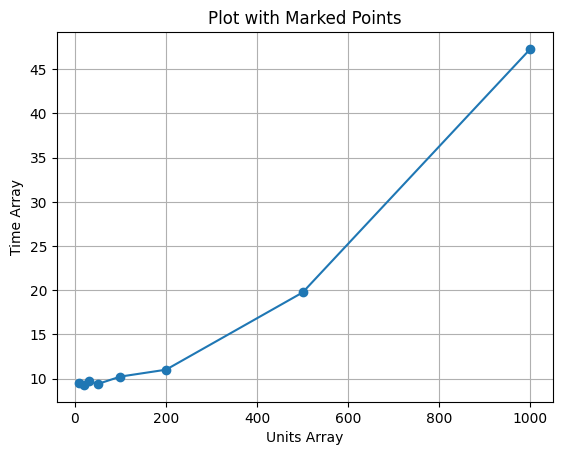

In [13]:
plt.plot(units_arr, time_arr, marker='o', linestyle='-')  # 'o' marker style with solid line
plt.xlabel('Units Array')
plt.ylabel('Time Array')
plt.title('Plot with Marked Points')
plt.grid(True)  # Add grid lines
plt.show()